# Imports

In [1]:
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import matplotlib.pyplot as plt
import logging
from src.model.vae import VAE
from src.utils.dataset import get_dataloader


# Losses

In [2]:
def kld_loss(mean, log_var):
    loss = - 0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return loss


def bce_loss(x, reconstruction):
    loss = torch.nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)



def vae_loss(x, mean, log_var, reconstruction):
    return bce_loss(x, reconstruction) + kld_loss(mean, log_var) 

# Model parameters

In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
logging.info(f"Device {device}")

criterion = vae_loss

autoencoder = VAE().to(device)

optimizer = torch.optim.Adam(autoencoder.parameters())

dataloader = get_dataloader('dsprites')

n_epochs = 4


# Train

  0%|          | 0/4 [00:00<?, ?it/s]

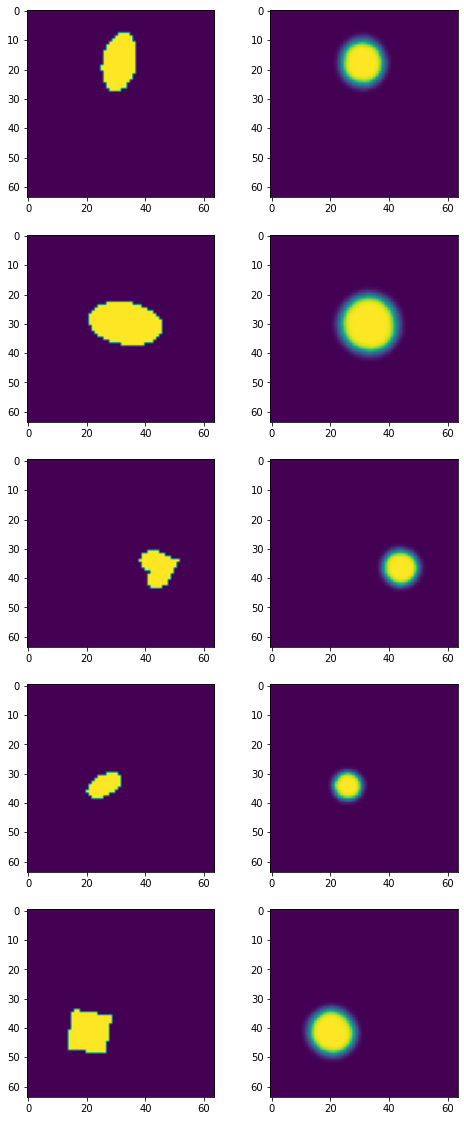

 25%|██▌       | 1/4 [01:04<03:12, 64.06s/it]

24601.297413635253


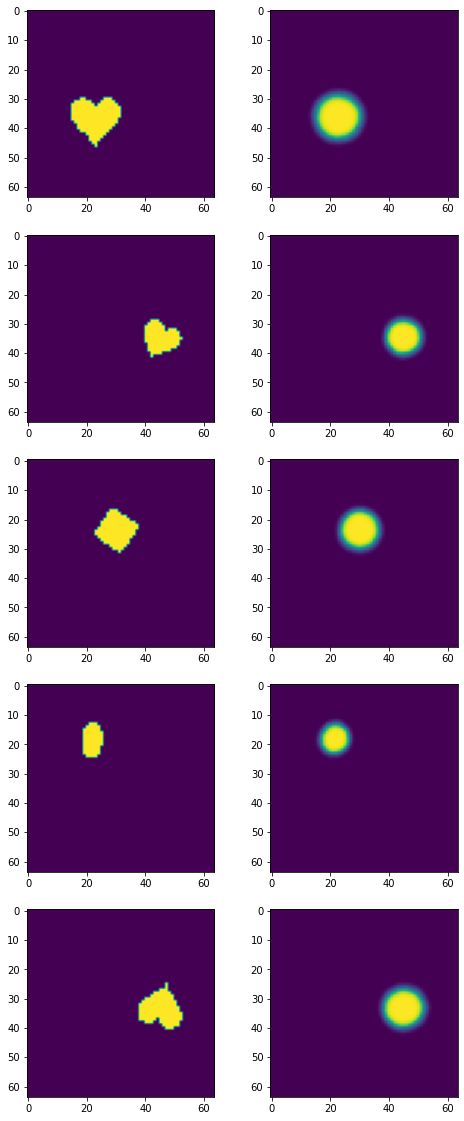

 50%|█████     | 2/4 [02:08<02:08, 64.14s/it]

14264.38552992079


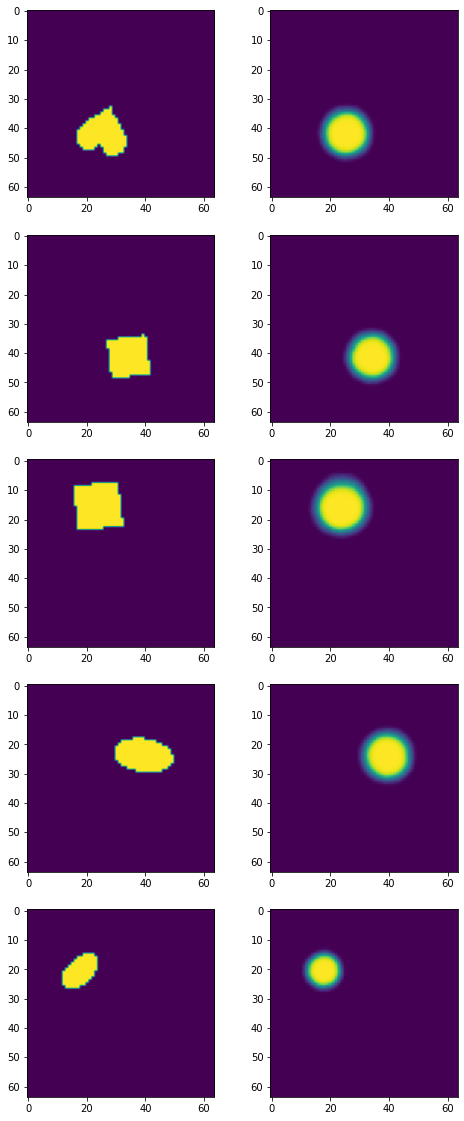

 75%|███████▌  | 3/4 [03:12<01:04, 64.05s/it]

14121.160019429524


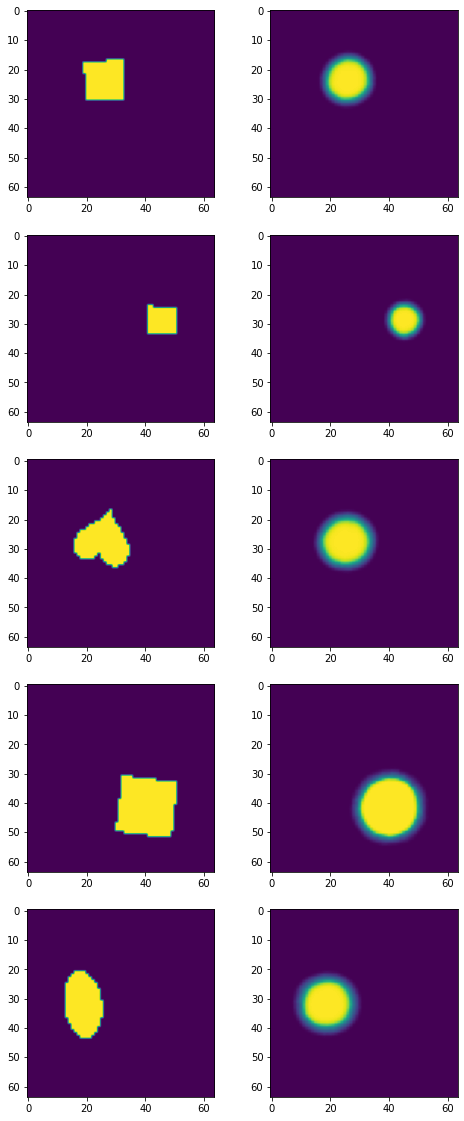

100%|██████████| 4/4 [04:16<00:00, 64.12s/it]

13916.537319437663


In [4]:
train_losses = []
val_losses = []

for epoch in tqdm(range(n_epochs)):
    autoencoder.train()
    train_losses_per_epoch = []
    for images_batch, parameters_batch in dataloader:
        optimizer.zero_grad()
        reconstruction, mean, log_var, latent_sample = autoencoder(images_batch.to(device))
        loss = criterion(images_batch.to(device).float(), mean, log_var, reconstruction)
        loss.backward()
        optimizer.step()
        batch_loss = loss.item()
        train_losses_per_epoch.append(batch_loss)

    autoencoder.eval()
    with torch.no_grad():
        for images_batch, parameters_batch in dataloader:
            reconstruction, mean, log_var, latent_sample = autoencoder(images_batch.to(device))
            result = reconstruction.cpu().detach().numpy()
            ground_truth = images_batch.numpy()
            break
    plt.figure(figsize=(8, 20))
    for i, (gt, res) in enumerate(zip(images_batch[:5].cpu().detach().numpy(), reconstruction[:5].cpu().detach().numpy())):
        plt.subplot(5, 2, 2 * i + 1)
        plt.imshow(gt.transpose(1, 2, 0))
        plt.subplot(5, 2, 2 * i + 2)
        plt.imshow(res.transpose(1, 2, 0))
    plt.show()
    epoch_loss = np.mean(train_losses_per_epoch)
    print(epoch_loss)
    train_losses.append(epoch_loss)

In [5]:
autoencoder.eval()
with torch.no_grad():
    for images_batch, parameters_batch in dataloader:
        reconstruction, mean, log_var, latent_sample = autoencoder(images_batch.to(device))
        reconstruction = reconstruction.view(-1, 1, 64, 64)
        result = reconstruction.cpu().detach().numpy()
        ground_truth = images_batch.numpy()
        break

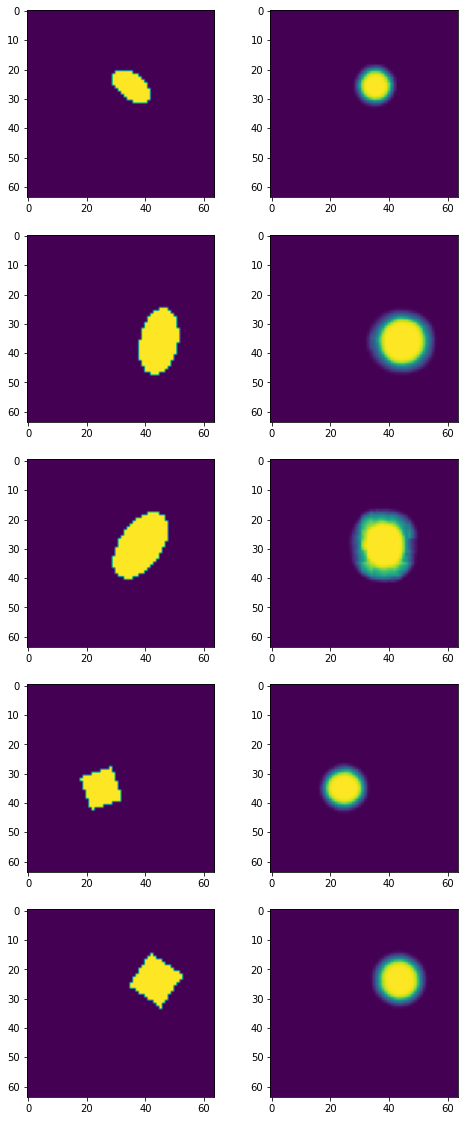

In [6]:
plt.figure(figsize=(8, 20))
for i, (gt, res) in enumerate(zip(ground_truth[:5], result[:5])):
    plt.subplot(5, 2, 2 * i + 1)
    plt.imshow(gt.transpose(1, 2, 0))
    plt.subplot(5, 2, 2 * i + 2)
    plt.imshow(res.transpose(1, 2, 0))

plt.show()